In [7]:
!pip install python-mnist

  Running setup.py bdist_wheel for python-mnist: started
  Running setup.py bdist_wheel for python-mnist: finished with status 'done'
  Stored in directory: C:\Users\tbop02\AppData\Local\pip\Cache\wheels\e3\67\aa\bea4c3dc84f590c0dabb8c00317b6b7f8e6bd43b095d7679d5
Successfully built python-mnist


In [24]:
import numpy as np

In [25]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

### when the above code doesn't respond, excute just the below

In [2]:
from mnist import MNIST
import numpy as np
mndata = MNIST('datasets/MNIST/')

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images=np.array(train_images)
train_labels=np.array(train_labels)
test_images=np.array(test_images)
test_labels=np.array(test_labels)

X=np.concatenate((train_images,test_images),axis=0)
y=np.concatenate((train_labels,test_labels),axis=0)

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


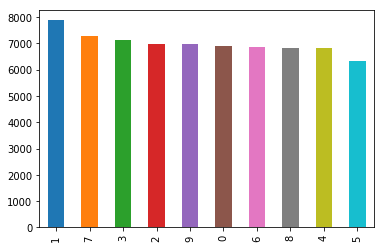

In [12]:
import pandas as pd
aa=pd.Series(y)
aa.value_counts().plot(kind='bar')

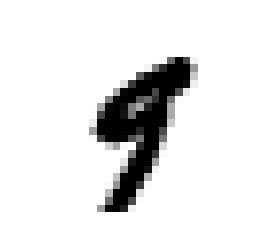

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000,:]
some_digit_image = some_digit.reshape((28, 28))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [25]:
y_train_5 = (y_train == 9) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 9)

In [40]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=50)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [41]:
sgd_clf.predict([some_digit])

array([False])

### Measuring Accuracy Using Cross-Validation

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 
skfolds = StratifiedKFold(n_splits=10, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #Constructs a new estimator with the same parameters.
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.9293451091484752
0.9416666666666667
0.9448333333333333
0.939
0.8901666666666667
0.9085
0.9328333333333333
0.9106666666666666
0.9191666666666667
0.9568261376896149


In [44]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=10, scoring="accuracy")

array([0.92934511, 0.94166667, 0.94483333, 0.939     , 0.89016667,
       0.9085    , 0.93283333, 0.91066667, 0.91916667, 0.95682614])

don't be suprised

**dumb classifier which classify every answer False**

In [45]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [46]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.89585, 0.90465, 0.90205])

In [48]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Confusion matrix

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[51791,  2260],
       [  955,  4994]], dtype=int64)

Precision and Recall

In [50]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4344 / (4344 + 1307)
print(recall_score(y_train_5, y_train_pred))

0.6884477529638819
0.839468818288788


In [83]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.6838849365914013

**Precision/Recall Tradeoff**

decision_function() method, which returns a score for each instance

In [88]:
y_scores = sgd_clf.decision_function([some_digit])
print('score',y_scores)
threshold = -20000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

score [-10488.93412238]
[ True]


In [87]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [89]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [90]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### Plot precision vs recall

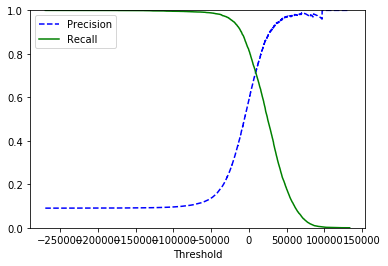

In [91]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

So let’s suppose you decide to aim for 90% precision.

In [97]:
y_train_pred_90 = (y_scores > 70000)
print('precision_score',precision_score(y_train_5, y_train_pred_90))
print('recall_score',recall_score(y_train_5, y_train_pred_90))

precision_score 0.9892857142857143
recall_score 0.051097583471684194


### The ROC Curve

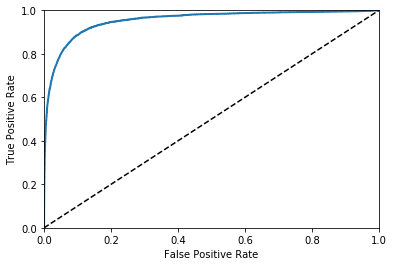

In [98]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [99]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9540136508477957

### RandomForestClassifier

In [101]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [102]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

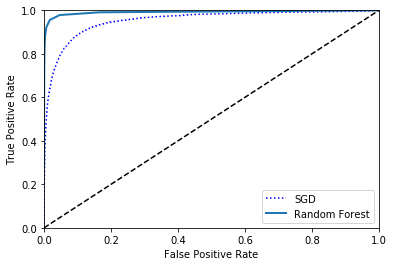

In [104]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

ROC curve looks much better than the SGDClassifier's

In [105]:
roc_auc_score(y_train_5, y_scores_forest)

0.9918928190344147

### Multiclass Classification

In [106]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Scikit-Learns detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA

In [107]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -74529.20494447,  -56275.68949771,  -78678.31378181,
          -6575.02882366,   -6629.43894421,  -10488.93412238,
        -112203.16511417,  -33694.00560765,  -27003.37394613,
          -8679.06551108]])

In [108]:
np.argmax(some_digit_scores)

3

In [109]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [111]:
sgd_clf.classes_[5]

5

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

If you want to force ScikitLearn to use one-versus-one or one-versus-all

OneVsOneClassifier or OneVsRestClassifierm

In [114]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=30))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

because 10C2

In [116]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=uint8)

In [119]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.9]])

it menas that random forest classifier predict this sample 9 with 90% probability

In [117]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88682264, 0.85304265, 0.88113217])

In [118]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90791842, 0.91504575, 0.91228684])

just simpy standardSCalar can increase accuracy because this is kind of SGD

### Error Analysis

In [122]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5704,    2,   23,    8,   12,   52,   41,    6,   70,    5],
       [   1, 6476,   48,   20,    6,   46,    5,    8,  118,   14],
       [  41,   34, 5333,  103,   84,   25,   91,   49,  187,   11],
       [  42,   31,  138, 5340,    2,  236,   31,   51,  166,   94],
       [  19,   22,   40,    9, 5349,   11,   47,   32,   95,  218],
       [  53,   31,   35,  183,   61, 4630,   93,   23,  211,  101],
       [  32,   22,   47,    2,   42,   89, 5616,    8,   59,    1],
       [  22,   20,   71,   28,   61,   10,    4, 5765,   30,  254],
       [  33,  112,   63,  133,    8,  139,   50,   15, 5185,  113],
       [  36,   28,   27,   77,  144,   32,    2,  183,  113, 5307]],
      dtype=int64)

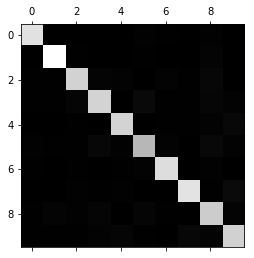

In [123]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

divide each value in the confusion matrix by the
number of images in the corresponding class

In [124]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

let’s fill the diagonal with zeros to keep only the errors

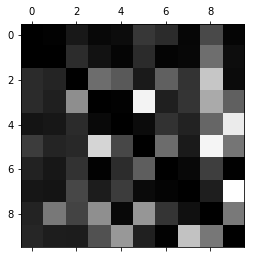

In [125]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

each rows represent actual class, while columns represent predicted classese.

classes 8 and 9 are quite bright,
which tells you that many images get misclassified as 8s or 9s.

1: this means that most 1s are classified correctly

should be spent on improving classification of 8s and 9s

not perfectly symmetric. there are more 5s
misclassified as 8s than the reverse.

In [128]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

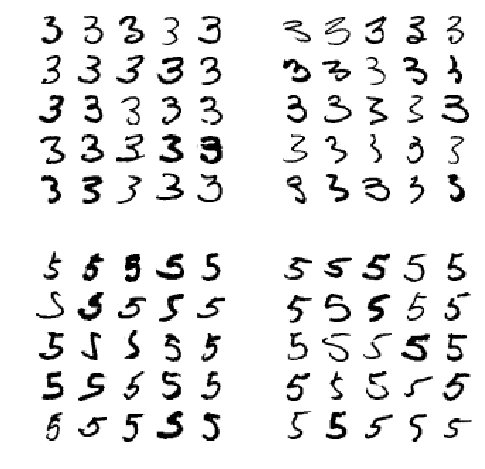

In [129]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on the right show
images classified as 5s.

<font color='red'>However, most misclassified images seem like obviouserrors to us, and it’s hard to understand why the classifier made the mistakes it did.3 The reason is that we
used a simple SGDClassifier, which is a linear model.</font>

If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5

### Multilabel Classification

KNeighborsClassifier instance (which supports multilabel classification)

In [130]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [132]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")